# Load Libraries

In [145]:
# NumPy
import numpy as np

# Dataframe operations
import pandas as pd

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Scalers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# Models
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn.linear_model import Perceptron
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Cross-validation
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
# GridSearchCV
from sklearn.model_selection import GridSearchCV

#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

# 1.0 Loading datasets

In [72]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
data_df = train_df.append(test_df) # The entire data: train + test.

# 2.0 Engineering features

Imputing Age

I make a Title feature for imputing ages more precisely. Median is used because ages distribution is not always normal, so it's generally preferred over mean. But I don't think this matters a lot, you can use mean too. I don't use Title feature for fitting models so it's discarded.

In [73]:
data_df['Title'] = data_df['Name']
# Cleaning name and extracting Title
for name_string in data_df['Name']:
    data_df['Title'] = data_df['Name'].str.extract('([A-Za-z]+)\.', expand=True)

# Replacing rare titles with more common ones
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss',
          'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
data_df.replace({'Title': mapping}, inplace=True)
titles = ['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev']
for title in titles:
    age_to_impute = data_df.groupby('Title')['Age'].median()[titles.index(title)]
    data_df.loc[(data_df['Age'].isnull()) & (data_df['Title'] == title), 'Age'] = age_to_impute
    
# Substituting Age values in TRAIN_DF and TEST_DF:
train_df['Age'] = data_df['Age'][:891]
test_df['Age'] = data_df['Age'][891:]

# Dropping Title feature
data_df.drop('Title', axis = 1, inplace = True)

Adding Family_Size

That's just Parch + SibSp.

In [74]:
data_df['Family_Size'] = data_df['Parch'] + data_df['SibSp']

# Substituting Age values in TRAIN_DF and TEST_DF:
train_df['Family_Size'] = data_df['Family_Size'][:891]
test_df['Family_Size'] = data_df['Family_Size'][891:]

Adding Family_Survival

This feature is from S.Xu's kernel, he groups families and people with the same tickets together and researches the info. I've cleaned the code a bit but it still does the same, I left it as is. For comments see the original kernel.

In [105]:
data_df['Last_Name'] = data_df['Name'].apply(lambda x: str.split(x, ",")[0])
data_df['Fare'].fillna(data_df['Fare'].mean(), inplace=True)

DEFAULT_SURVIVAL_VALUE = 0.5
data_df['Family_Survival'] = DEFAULT_SURVIVAL_VALUE

for grp, grp_df in data_df[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    if (len(grp_df) != 1):
        # A Family group is found.
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 0

print("Number of passengers with family survival information:", 
      data_df.loc[data_df['Family_Survival']!=0.5].shape[0])

Number of passengers with family survival information: 420


In [106]:
data_df.Family_Survival.value_counts()

0.5    889
1.0    218
0.0    202
Name: Family_Survival, dtype: int64

In [107]:
for _, grp_df in data_df.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 0
                        
print("Number of passenger with family/group survival information: " 
      +str(data_df[data_df['Family_Survival']!=0.5].shape[0]))

# # Family_Survival in TRAIN_DF and TEST_DF:
train_df['Family_Survival'] = data_df['Family_Survival'][:891]
test_df['Family_Survival'] = data_df['Family_Survival'][891:]

Number of passenger with family/group survival information: 546


In [108]:
data_df.Family_Survival.value_counts()

0.5    763
1.0    303
0.0    243
Name: Family_Survival, dtype: int64

Making FARE BINS

It's ordinal. FareBin = 3 is indeed greater than FareBin = 1. I've seen people turning it into dummies for some reason...

In [110]:
data_df.isnull().sum()

Age                   0
Cabin              1014
Embarked              2
Fare                  0
Name                  0
Parch                 0
PassengerId           0
Pclass                0
Sex                   0
SibSp                 0
Survived            418
Ticket                0
Family_Size           0
Last_Name             0
Family_Survival       0
dtype: int64

In [116]:
# Making Bins
data_df['FareBin'] = pd.qcut(data_df['Fare'], 5)
label = LabelEncoder()
data_df['FareBin_Code'] = label.fit_transform(data_df['FareBin'])

train_df['FareBin_Code'] = data_df['FareBin_Code'][:891]
test_df['FareBin_Code'] = data_df['FareBin_Code'][891:]

train_df.drop(['Fare'], 1, inplace=True)
test_df.drop(['Fare'], 1, inplace=True)

Making AGE BINS

Note here that it is better to use the entire dataset for mean/median/mode calculation, otherwise we will miss out useful information.

In [118]:
data_df['AgeBin'] = pd.qcut(data_df['Age'], 4)

label = LabelEncoder()
data_df['AgeBin_Code'] = label.fit_transform(data_df['AgeBin'])

train_df['AgeBin_Code'] = data_df['AgeBin_Code'][:891]
test_df['AgeBin_Code'] = data_df['AgeBin_Code'][891:]

train_df.drop(['Age'], 1, inplace=True)
test_df.drop(['Age'], 1, inplace=True)

Mapping SEX and cleaning data (dropping garbage)

In [120]:
train_df['Sex'].replace(['male','female'],[0,1],inplace=True)
test_df['Sex'].replace(['male','female'],[0,1],inplace=True)

train_df.drop(['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin',
               'Embarked'], axis = 1, inplace = True)
test_df.drop(['Name','PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin',
              'Embarked'], axis = 1, inplace = True)

In [119]:
data_df

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Last_Name,Family_Survival,FareBin,FareBin_Code,AgeBin,AgeBin_Code
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,1,Braund,0.5,"(-0.001, 7.854]",0,"(0.169, 22.0]",0
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,1,Cumings,0.5,"(41.579, 512.329]",4,"(36.0, 80.0]",3
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,0,Heikkinen,0.5,"(7.854, 10.5]",1,"(22.0, 30.0]",1
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,1,Futrelle,0.0,"(41.579, 512.329]",4,"(30.0, 36.0]",2
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,0,Allen,0.5,"(7.854, 10.5]",1,"(30.0, 36.0]",2
5,30.0,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877,0,Moran,0.5,"(7.854, 10.5]",1,"(22.0, 30.0]",1
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463,0,McCarthy,0.5,"(41.579, 512.329]",4,"(36.0, 80.0]",3
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909,4,Palsson,0.0,"(10.5, 21.679]",2,"(0.169, 22.0]",0
8,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742,2,Johnson,1.0,"(10.5, 21.679]",2,"(22.0, 30.0]",1
9,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736,1,Nasser,0.0,"(21.679, 41.579]",3,"(0.169, 22.0]",0


# 3.0 Model

Training

Creating X and y

In [122]:
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']
X_test = test_df.copy()

Scaling features

In [123]:
std_scaler = StandardScaler()
X = std_scaler.fit_transform(X)
X_test = std_scaler.transform(X_test)

# 3.1 Grid Search CV

Here I use KNN.

In [126]:
n_neighbors = [6,7,8,9,10,11,12,14,16,18,20,22]
algorithm = ['auto']
weights = ['uniform', 'distance']
leaf_size = list(range(1,50,5))
hyperparams = {'algorithm': algorithm, 'weights': weights, 'leaf_size': leaf_size, 
               'n_neighbors': n_neighbors}
gd=GridSearchCV(estimator = KNeighborsClassifier(), param_grid = hyperparams, verbose=True, 
                cv=10, scoring = "roc_auc",n_jobs=4)
gd.fit(X, y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=4)]: Done 127 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 1927 tasks      | elapsed:    8.3s


0.879492358564122
KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=18, p=2,
           weights='uniform')


[Parallel(n_jobs=4)]: Done 2400 out of 2400 | elapsed:    9.5s finished


In case you get a different result here (result may vary), what I got was:

KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=18, p=2, weights='uniform')

This gave 0.884103388207 ROC_AUC score (not accuracy score!). I had a ton of models with roc_auc around 0.93-0.94 but when tested, they mostly showed lower results. Doesn't mean they are worse though.

In [127]:
gd.best_estimator_.fit(X, y)
y_pred = gd.best_estimator_.predict(X_test)

In [132]:
sub = pd.read_csv('gender_submission.csv')
sub['Survived'] = y_pred
sub.to_csv('Sub_KNN.csv',index=False)

In [133]:
knn = KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski', 
                           metric_params=None, n_jobs=1, n_neighbors=6, p=2, 
                           weights='uniform')
knn.fit(X, y)
y_pred = knn.predict(X_test)

In [134]:
sub = pd.read_csv('gender_submission.csv')
sub['Survived'] = y_pred
sub.to_csv('Sub_KNN.csv',index=False)

# 3.2 Result

So when I submitted the score I got 0.83253.

# 4.0 Cross validate models

In [147]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))

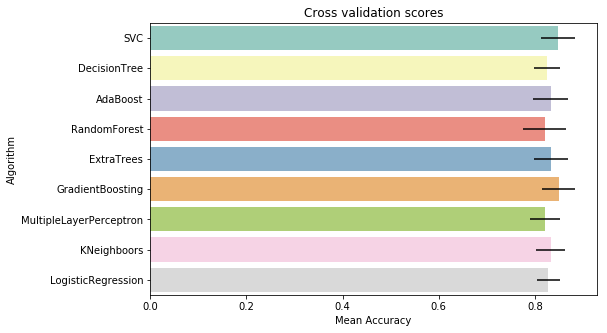

In [149]:
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X, y = y, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression"]})

plt.figure(figsize=(8,5))
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

I will use XGBoost

# 4.1 XGBoost

In [151]:
import xgboost as xgb
from xgboost import XGBClassifier

In [157]:
n_estimators = [100,200,300,400,500]
learning_rate = [0.001,0.01,0.1,0.3]
max_depth = [3,6,10,15,30]
colsample_bytree = [0.5,0.75,1]
gamma = [0,0.3,0.8,2,5]
reg_alpha = [0,0.3,0.8,2,5]

hyperparams = {'n_estimators': n_estimators, 'learning_rate': learning_rate, 
               'max_depth': max_depth, 'colsample_bytree' : colsample_bytree,
              'gamma' : gamma, 'reg_alpha' : reg_alpha}
gd=GridSearchCV(estimator = XGBClassifier(), param_grid = hyperparams, verbose=True, 
                cv=10, scoring = "accuracy",n_jobs=4)
gd.fit(X, y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 10 folds for each of 7500 candidates, totalling 75000 fits


[Parallel(n_jobs=4)]: Done  80 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 740 tasks      | elapsed:   24.1s
[Parallel(n_jobs=4)]: Done 1490 tasks      | elapsed:   49.0s
[Parallel(n_jobs=4)]: Done 2540 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 3959 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 6167 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8221 tasks      | elapsed:  4.5min
[Parallel(n_jobs=4)]: Done 9988 tasks      | elapsed:  6.0min
[Parallel(n_jobs=4)]: Done 11384 tasks      | elapsed:  7.7min
[Parallel(n_jobs=4)]: Done 13000 tasks      | elapsed:  9.7min
[Parallel(n_jobs=4)]: Done 14759 tasks      | elapsed: 11.9min
[Parallel(n_jobs=4)]: Done 16662 tasks      | elapsed: 14.4min
[Parallel(n_jobs=4)]: Done 18683 tasks      | elapsed: 17.1min
[Parallel(n_jobs=4)]: Done 20995 tasks      | elapsed: 19.9min
[Parallel(n_jobs=4)]: Done 23392 tasks      | elapsed: 22.8min
[Parallel(n_jobs=4)]: Done 25787 tasks      | elapsed: 25.9min
[P

0.8574635241301908
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.8, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [158]:
gd.best_estimator_.fit(X, y)
y_pred = gd.best_estimator_.predict(X_test)
sub = pd.read_csv('gender_submission.csv')
sub['Survived'] = y_pred
sub.to_csv('Sub_XGB.csv',index=False)

C:\Users\Martin\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
